# Decision: Where to Go?

# Import libraries

In [2]:
# Import some packages from matplotlib

%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Read Image

In [3]:
# read the example image

image = mpimg.imread('images/sample.jpg')

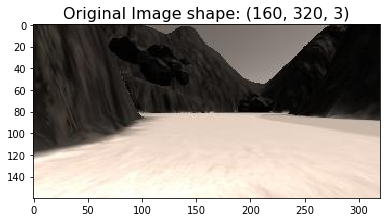

In [4]:
# Show the image and shape

f, (ax1) = plt.subplots(1, 1,figsize=(12, 3))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image shape: '+str(image.shape), fontsize=16)

plt.show()

# Wrapping Function

In [5]:
# define function to transform the image

def perspect_transform(img, src, dst):

    # Get transform matrix using cv2.getPerspectivTransform()
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp image using cv2.warpPerspective()
    # keep same size as input image
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    # Return the result
    return warped

In [6]:
# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel squaimagere represents 1 square meter

hs_size = 10/2             # half the size of one square
b_ofst  = 6                # bottom offset to account for distance from rover edge to 1st camera visiable point
x_cntr  = image.shape[1]/2 # center of the image x axis
y_end   = image.shape[0]   # end of y or bottom of image

source      = np.float32([
                  [14, 140],      # Left Bottom
                  [301 ,140],     # Right Bottom
                  [200, 96],      # Right Top
                  [118, 96]       # Left Top
                  ])              # above data captured from simulator

destination = np.float32([
                  [x_cntr - hs_size, y_end - b_ofst],             # Left Bottom
                  [x_cntr + hs_size, y_end - b_ofst],             # Right Bottom
                  [x_cntr + hs_size, y_end - 2*hs_size - b_ofst], # Right Top
                  [x_cntr - hs_size, y_end - 2*hs_size - b_ofst], # Left Top
                  ])

# Color Thresholding Function

In [7]:
# function that will return a mask with all pixels above a certian color threshold

def color_thresh(img, rgb_thresh=(0, 0, 0)):

    color_select = np.zeros_like(img[:,:,0])

    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])

    color_select[above_thresh] = 1

    return color_select

In [8]:
# Define color selection criteria

red_threshold = 160
green_threshold = 160
blue_threshold = 160

rgb_threshold = (red_threshold, green_threshold, blue_threshold)

# Rover-Centric Coordinates Function

In [9]:
def rover_coords(binary_img):

    ypos, xpos = binary_img.nonzero()
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel

# Rotation

In [10]:
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

# Translation

In [11]:
def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated

# Rotation and Translation (and clipping)

In [12]:
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Clip to world_size
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world


# Convert from cartesian to polar coordinates

In [25]:
def to_polar_coords(xpix, ypix):
    # Calculate distance to each pixel
    dist = np.sqrt(xpix**2 + ypix**2)
    # Calculate angle using arctangent function
    angles = np.arctan2(ypix, xpix)
    return dist, angles

# Perform Warping

In [13]:
warped = perspect_transform(image, source, destination)

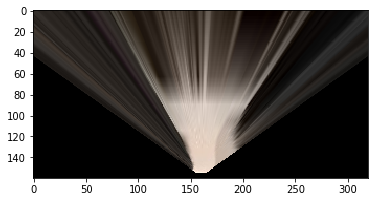

In [14]:
plt.imshow(warped)
plt.show()

# Perform Thresholding

In [15]:
colorsel = color_thresh(warped, rgb_threshold)

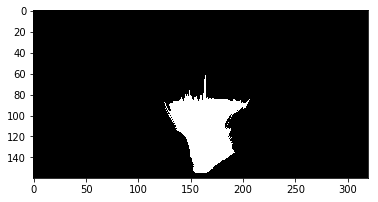

In [16]:
plt.imshow(colorsel, cmap='gray')
plt.show()

# Perform Rover-Centric Coordinates

In [17]:
xpix, ypix = rover_coords(colorsel)

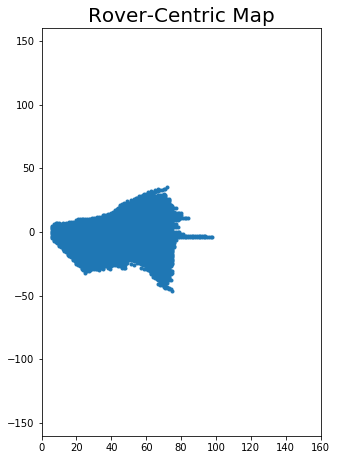

In [18]:
# Plot the map in rover-centric coords
fig = plt.figure(figsize=(5, 7.5))
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
plt.title('Rover-Centric Map', fontsize=20)
plt.show() # Uncomment if running on your local machine

# Generate random X,Y,Yaw for Robot position

In [19]:
# Rover yaw values will come as floats from 0 to 360
# Generate a random value in this range
# Note: you need to convert this to radians
    # before adding to pixel_angles
rover_yaw = np.random.random(1)*360

# Generate a random rover position in world coords
# Position values will range from 20 to 180 to 
# avoid the edges in a 200 x 200 pixel world
rover_xpos = np.random.random(1)*160 + 20
rover_ypos = np.random.random(1)*160 + 20

# Note: Since we've chosen random numbers for yaw and position, 
# multiple run of the code will result in different outputs each time.

print('Xpos =', rover_xpos, 'Ypos =', rover_ypos, 'Yaw =', rover_yaw)

Xpos = [ 116.71263213] Ypos = [ 176.34605712] Yaw = [ 100.36566532]


In [20]:
worldmap = np.zeros((200, 200))
scale = 10

In [21]:
# Get navigable pixel positions in world coords
x_world, y_world = pix_to_world(xpix, ypix, rover_xpos, 
                                rover_ypos, rover_yaw, 
                                worldmap.shape[0], scale)

In [22]:
# Add pixel positions to worldmap
worldmap[y_world, x_world] += 1

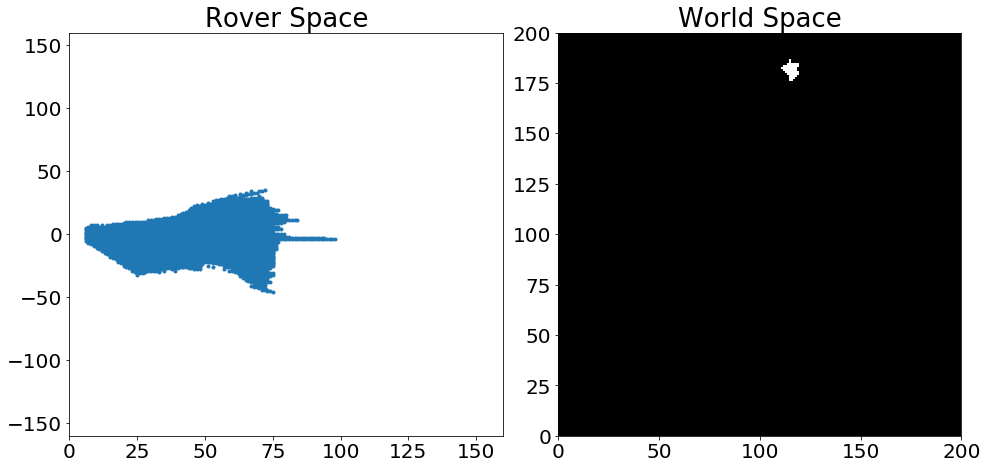

In [23]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
f.tight_layout()

ax1.plot(xpix, ypix, '.')
ax1.set_title('Rover Space', fontsize=26)
ax1.set_ylim(-160, 160)
ax1.set_xlim(0, 160)
ax1.tick_params(labelsize=20)

ax2.imshow(worldmap, cmap='gray')
ax2.set_title('World Space', fontsize=26)
ax2.set_ylim(0, 200)
ax2.tick_params(labelsize=20)
ax2.set_xlim(0, 200)

plt.subplots_adjust(left=0.1, right=1, top=0.9, bottom=0.1)
plt.show()

# Deciding Distance & Angle

In [51]:
distances, angles = to_polar_coords(xpix, ypix) # Convert to polar coords
avg_angle = np.mean(angles) # Compute the average angle
avg_angle_degrees = avg_angle * 180/np.pi

steering = np.clip(avg_angle_degrees, -15, 15) # limit angle given the approximate field of view of the camera

print("Decided Steering angle =",steering)

Decided Steering angle = -6.32291704086


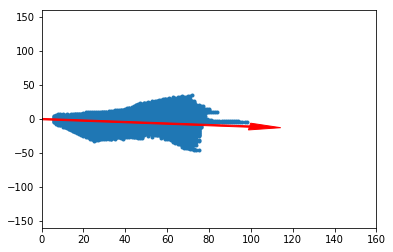

In [57]:
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)

arrow_length = 100
x_arrow = arrow_length * np.cos(avg_angle)
y_arrow = arrow_length * np.sin(avg_angle)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)

plt.show()